In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import scipy.signal as sig
import scipy.interpolate as interp

In [2]:
Tdict = {120:1.,
         110:0.95,
         100:0.85,
         90:0.8,
         80:0.7,
         70:0.65,
         60:0.5,
         50:0.38,
         40:0.25,
         30:0.18,
         20:0.1,
         10:0.05,
         0:0.0}

r,g,b = [],[],[]
rtup,gtup,btup = [],[],[]
Tsorted = [(k,v) for k,v in Tdict.items()]
Tsorted.sort()
for t,v in Tsorted:
    tmp = mpl.cm.nipy_spectral(v)
    r = tmp[0]
    g = tmp[1]
    b = tmp[2]
    tn = t/120
    rtup.append((tn,r,r))
    gtup.append((tn,g,g))
    btup.append((tn,b,b))
cdict = {'red':rtup,'green':gtup,'blue':btup}
tmap = mpl.colors.LinearSegmentedColormap('tempmap',cdict)




In [3]:
def get_average_hourly_temp(file, GMT_offset=0.):
    df = pd.read_table(file, 
                       delimiter='\s+', 
                       skipinitialspace=True, 
                       na_values=['*','**','***','****','*****','******'], 
                       parse_dates=['YR--MODAHRMN'], 
                       index_col='YR--MODAHRMN',
                      usecols=['YR--MODAHRMN','TEMP'])
    df.dropna(axis=1, how='all', inplace=True)
    df['hour'] = (df.index.hour+GMT_offset)%24
    df['dayofyear'] = df.index.dayofyear
    dfday = df.groupby(['dayofyear','hour'])
    dyhrtemp = dfday['TEMP'].mean()
    temps = dyhrtemp.unstack().values
    return df, temps

def smooth_temps(temps,s=1.6e5):
    days = np.linspace(0,366,366)
    hours = np.linspace(0,24,366)
    tbiv = interp.RectBivariateSpline(range(24),range(366),temps.T,s=0)
    tinterp = tbiv(hours, days)
    tbiv2 = interp.RectBivariateSpline(days, days,tinterp, s=s)
    tsmooth = tbiv2(days,days)
    return tsmooth

In [5]:
file = '340047389300dat.txt'
df, temps = get_average_hourly_temp(file, GMT_offset=-7)

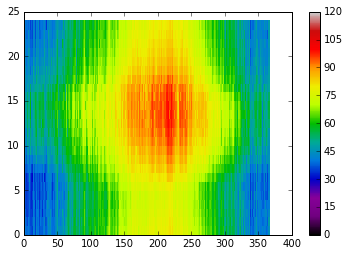

In [6]:
plt.pcolormesh(temps.T,vmin=0,vmax=120,cmap=tmap)
plt.colorbar()

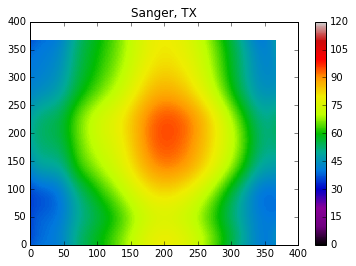

In [15]:
tsmooth = smooth_temps(temps,s=10e5)
plt.pcolormesh(tsmooth,vmin=0,vmax=120,cmap=tmap)
plt.colorbar()
plt.title('Sanger, TX')

# Other Options 

(0, 24)

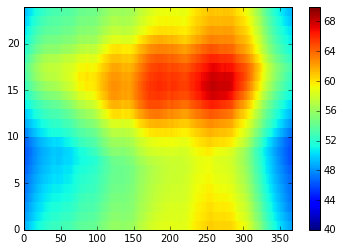

In [207]:
tfilt = sig.savgol_filter(temps, window_length = 59, polyorder=2, axis=0)
tplt = tfilt.T
plt.pcolormesh(tplt,vmin=40, vmax=70)
plt.colorbar()
plt.xlim(0,366)
plt.ylim(0,24)

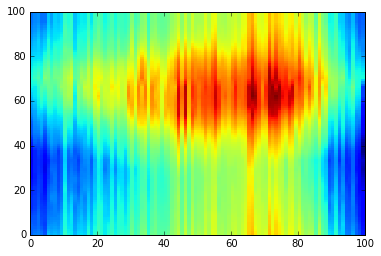

In [18]:
tinterp = interp.interp2d(range(366),range(24),temps.T)
days = np.linspace(0,366,100)
hours = np.linspace(0,24,100)
tsmooth = tinterp( days,hours)
plt.pcolormesh(tsmooth)